In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [110]:
def setup_all_seed(seed=0):
    # numpyに関係する乱数シードの設定
    np.random.seed(seed)
    
    # pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

setup_all_seed()

In [111]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
#############################################
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#############################################
trainset = torchvision.datasets.CIFAR10(
    root = "./data",
    train=True,
    download=True,
    transform=transform,
)
testset = torchvision.datasets.CIFAR10(
    root = "./data",
    train=False,
    download=True,
    transform=transform,
)

In [113]:
print(len(trainset))
# print(trainset[0])

data, label = trainset[0]
print(f"{data=}")
print(f"{label=}")

50000
data=tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961,

In [114]:
#############################################
batch_size = 100

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
)

testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
)

In [115]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

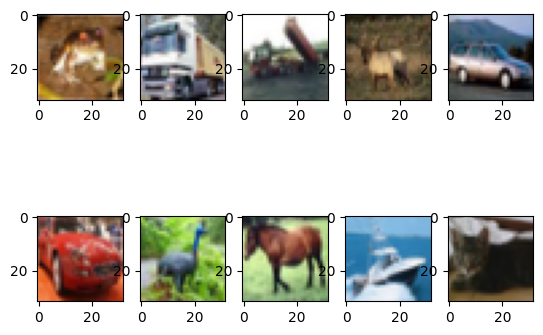

In [116]:
for i in range(10):
    data = trainset[i][0]
    data_p = torch.permute(data, (1,2,0))    
    plt.subplot(2,5, i+1)
    plt.imshow(data_p)
plt.show()



In [117]:
for images, labels in trainloader:
    break

labels[:10]

tensor([4, 3, 9, 0, 1, 7, 2, 0, 7, 7])

In [118]:
data, label = trainset[0]

data.shape

torch.Size([3, 32, 32])

In [119]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.dropout_2d=nn.Dropout2d(0.25)
        self.dropout_1d= nn.Dropout(0.5)
        
        
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=3,
            padding=1,
        )
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            padding=1,
        )
        
        self.conv3 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1,
        )
        self.conv4 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=3,
            padding=1,
        )
        
        self.fc1 = nn.Linear(4096, 512)
        self.fc2 = nn.Linear(512, 10)
        
        self.conv_block1 = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.pool,
            self.dropout_2d
        )
        self.conv_block2 = nn.Sequential(
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.pool,
            self.dropout_2d
        )
        self.classifier_block = nn.Sequential(
            self.fc1,
            self.relu,
            self.dropout_1d,
            self.fc2
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.flatten(x)
        x = self.classifier_block(x)
        return x        
        
        

In [120]:
for images, labels in trainloader:
    images = images.to(device)
    labels = labels.to(device)
    break


model = Net()
model = model.to(device)
out = model(images)
print(out.shape)

torch.Size([100, 10])


In [121]:
# loss func
criterion = nn.CrossEntropyLoss()

# optimiser
optimiser = optim.Adam(model.parameters(), lr=0.001)

In [122]:
num_epochs = 30

history = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
}

for epoch in tqdm(range(num_epochs)):
    # ============================================
    model.train()
    
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_train_samples = 0
    
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        # training models
        optimiser.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        
        # compute loss
        # wight by the batch size 
        # because loss.item() automatically compute average loss.
        epoch_loss += loss.item() * len(images)
        
        # calc model performance
        preds = outputs.argmax(dim=1)
        epoch_accuracy += (preds == labels).sum().item()
        
        # count up the accumulated volumes of samples which the model has already seen.
        num_train_samples += len(images)
    
    avg_train_loss = epoch_loss / num_train_samples
    avg_train_accuracy = epoch_accuracy / num_train_samples
    
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(avg_train_accuracy)
    
    # ============================================
    model.eval()
    
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_test_samples = 0    
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(testloader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # compute loss
            # wight by the batch size 
            # because loss.item() automatically compute average loss.
            epoch_loss += loss.item() * len(images)
            
            # calc model performance
            preds = outputs.argmax(dim=1)
            epoch_accuracy += (preds == labels).sum().item()
            
            # count up the accumulated volumes of samples which the model has already seen.
            num_test_samples += len(images)
    
    avg_test_loss = epoch_loss / num_test_samples
    avg_test_accuracy = epoch_accuracy / num_test_samples
    
    history["test_loss"].append(avg_test_loss)
    history["test_acc"].append(avg_test_accuracy)


100%|██████████| 30/30 [07:54<00:00, 15.82s/it]


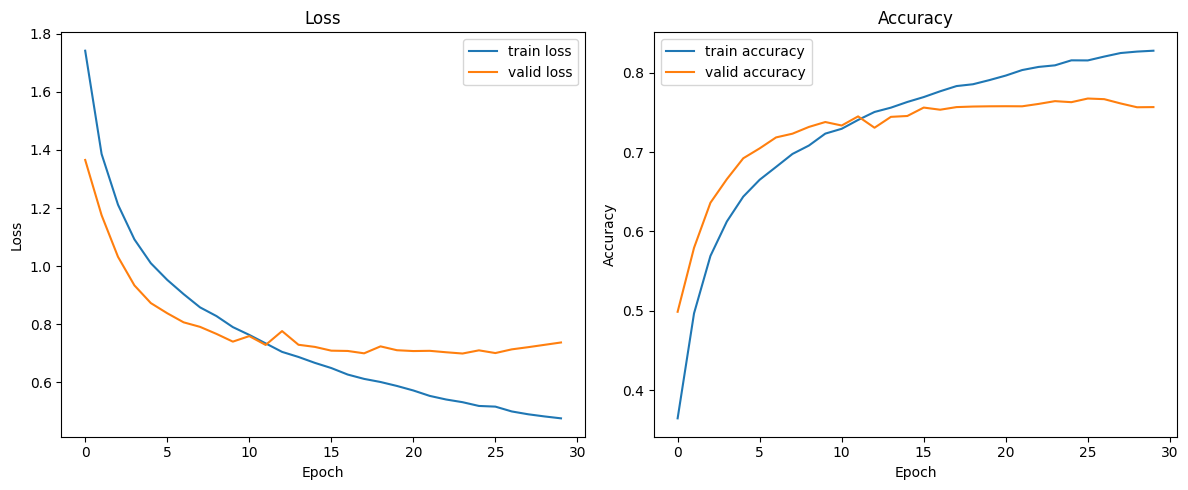

In [123]:
num_epochs = len(history["train_loss"])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), history["train_loss"], label="train loss")
plt.plot(range(num_epochs), history["test_loss"], label="valid loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")


plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), history["train_acc"], label="train accuracy")
plt.plot(range(num_epochs), history["test_acc"], label="valid accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.show()